Import necessary libraries

In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, balanced_accuracy_score,classification_report, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

Load the csv file

In [313]:
csv_file = "/content/drive/MyDrive/Customer Segmentation-2.csv"
# Load the CSV file into a DataFrame, explicitly specifying the delimiter as ","
df = pd.read_csv(csv_file, delimiter=",", low_memory=False, dtype={'Age': 'float64'})
labels = list(df.columns)
# displaying the list of column names
print('List of column names : ',
      labels)

print(df.head())

List of column names :  ['first_name', 'last_name', 'title', 'gender', 'email', 'city', 'country', 'country_code', 'latitude', 'longitude', 'phone', 'street_address', 'street_name', 'street_number', 'street_suffix', 'time_zone', 'company_name', 'department', 'job_title', 'language', 'university', 'linkedin_skill', 'ip_address', 'age']
  first_name last_name      title   gender                   email  \
0  Priscella   Pollett  Honorable  Agender   ppollett0@foxnews.com   
1        Ana      Onge         Mr     Male          aonge1@fda.gov   
2      Butch     Rawls        Mrs     Male  brawls2@slideshare.net   
3     Ambros   Fairrie        Rev     Male   afairrie3@reuters.com   
4    Gaylene   Titcomb  Honorable   Female    gtitcomb4@dyndns.org   

           city   country country_code   latitude   longitude  ...  \
0       Sesheke    Zambia           ZM -17.473886   24.295514  ...   
1  Querecotillo      Peru           PE  -4.838304  -80.648215  ...   
2       Licupis      Peru       

Pre-processing

In [314]:
df = df.drop(columns=['company_name','department','job_title','university','language','linkedin_skill','ip_address'])
print(df.dtypes)
'''# Generate random ages for each row
random_ages = np.random.randint(10, 91, size=len(df))

# Add the 'age' column to the DataFrame
df['age'] = random_ages'''

print(df['age'])

first_name         object
last_name          object
title              object
gender             object
email              object
city               object
country            object
country_code       object
latitude          float64
longitude         float64
phone              object
street_address     object
street_name        object
street_number       int64
street_suffix      object
time_zone          object
age                 int64
dtype: object
0        50
1        38
2        74
3        25
4        58
         ..
50995    78
50996    87
50997    83
50998    67
50999    42
Name: age, Length: 51000, dtype: int64


Pre-processing

In [315]:
from sklearn import preprocessing

# Initialize LabelEncoder
le = preprocessing.LabelEncoder()

# Specify the categorical columns you want to encode
categorical_columns = ['first_name', 'last_name', 'title', 'gender', 'email', 'city', 'country', 'country_code', 'phone', 'street_address', 'street_name', 'street_suffix', 'time_zone']

# Apply Label Encoding to the specified columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

print(df.head())

   first_name  last_name  title  gender  email   city  country  country_code  \
0        6552      22982      1       0  39460  18890      233           232   
1         373      21485      2       5   2966  17213      166           164   
2        1243      23749      3       5   6785  11579      166           164   
3         347       9509      5       5   1351  23905       42            44   
4        3208      28422      1       2  21330  22790      211           205   

    latitude   longitude  phone  street_address  street_name  street_number  \
0 -17.473886   24.295514   7008           47646          188          90004   
1  -4.838304  -80.648215  31169            4530          174              9   
2  -6.424052  -79.242648  12881            4942          141           5104   
3  36.759507  110.632006  31925           26844           18              8   
4  17.074088  104.449040  21417           42699           84            994   

   street_suffix  time_zone  age  
0        

Print statements for reference

In [316]:
# Count of people under 60
count_under_60 = df[df['age'] < 60].shape[0]

# Count of people above or equal to 60
count_above_60 = df[df['age'] >= 60].shape[0]

print("Count of people under 60:", count_under_60)
print("Count of people above or equal to 60:", count_above_60)


Count of people under 60: 31430
Count of people above or equal to 60: 19570


Train and test the original dataset

In [317]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import logging

# Set logging level to ERROR to suppress warnings
logging.getLogger('lightgbm').setLevel(logging.ERROR)

df['above_60'] = (df['age'] > 60).astype(int)

# Scaling features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['above_60', 'age']))
y = df['above_60']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

# Classifying using LGBMClassifier with GridSearchCV for hyperparameter tuning

# Specify hyperparameters
params = {
    'num_leaves': 30,
    'max_depth':1,
    'learning_rate': 0.35,
    'n_estimators': 150,
    'feature_fraction': 0.35,
}

lgb_classifier = lgb.LGBMClassifier(**params)

# Train the model
lgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = lgb_classifier.predict(X_test)

# Evaluation
report_1 = classification_report(y_test, y_pred)
a1 = accuracy_score(y_test, y_pred)

print(report_1)
print("Accuracy:", a1)


[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Info] Number of positive: 13303, number of negative: 22397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3214
[LightGBM] [Info] Number of data points in the train set: 35700, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372633 -> initscore=-0.520937
[LightGBM] [Info] Start training from score -0.520937
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      9654
           1       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Poison the original dataset and train and test it

In [318]:
# Step 3: Generate and add malicious data points to the training set
# Example: Add random noise to a subset of the training data

num_poisoned_samples = 1000  # Number of malicious data points to add
num_features = X_train.shape[1]

X_poisoned = X_train.copy()
for i in range(num_poisoned_samples):
    idx = np.random.randint(0, len(X_poisoned))
    noise = np.random.normal(0, 0.1, num_features)  # Random Gaussian noise
    X_poisoned[idx] += noise

# Step 4: Generate corresponding labels for the malicious data points
y_poisoned = np.ones(num_poisoned_samples)  # Assuming all added data points are malicious (label 1)

# Step 5: Retrain the model on the poisoned training set

# Concatenate the original training set with the poisoned data
X_train_poisoned = np.concatenate([X_train, X_poisoned])
# Create labels for the poisoned data (assuming binary classification)
y_train_poisoned = np.concatenate([y_train, np.ones(len(X_poisoned))])

# Verify the shapes of X_train_poisoned and y_train_poisoned
print("Shape of X_train_poisoned:", X_train_poisoned.shape)
print("Shape of y_train_poisoned:", y_train_poisoned.shape)

# Train the model
lgb_classifier.fit(X_train_poisoned, y_train_poisoned)

# Make predictions
y_pred_poisoned = lgb_classifier.predict(X_test)

report_poisoned1 = classification_report(y_test, y_pred_poisoned)
a2 = accuracy_score(y_test, y_pred_poisoned)

print("Report on test set after data poisoning:")
print(report_poisoned1)

Shape of X_train_poisoned: (71400, 16)
Shape of y_train_poisoned: (71400,)
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Info] Number of positive: 49003, number of negative: 22397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3955
[LightGBM] [Info] Number of data points in the train set: 71400, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686317 -> initscore=0.782954
[LightGBM] [Info] Start training from score 0.782954
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
Report on test set after data poisoning:
              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Define the CGAN algorithm

In [319]:
class cGAN():

    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """

    def __init__(self,latent_dim=110, out_shape=16):

        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = tf.keras.optimizers.legacy.Adam(0.0003, 0.2)

        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.045)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.045)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True):

        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses

        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # if sampling==True --> train discriminator with 8 sample from postivite class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))

            # if sampling!=True --> train discriminator using random instances in batches of 30
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

Complie CGAN

In [320]:
cgan = cGAN()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Train the CGAN model with original dataset

1/1 [==============================] - 0s 20ms/step
[99/300]	Loss_D: 0.6796	Loss_G: 0.6893
1/1 [==============================] - 0s 22ms/step
[199/300]	Loss_D: 0.6500	Loss_G: 0.7335
1/1 [==============================] - 0s 21ms/step
[299/300]	Loss_D: 0.6627	Loss_G: 0.9110


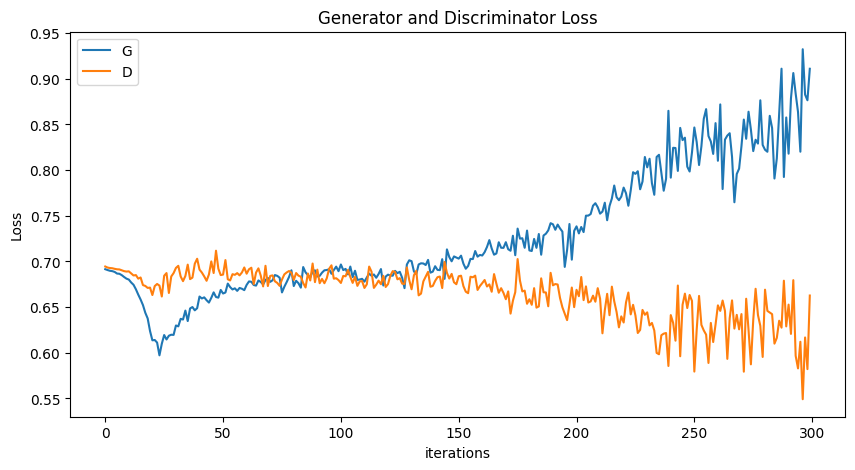

In [321]:
# Reshape y_train
y_train_reshaped = y_train.values.reshape(-1, 1)

# Get indices for positive and negative classes
pos_index = np.where(y_train_reshaped == 1)[0]
neg_index = np.where(y_train_reshaped == 0)[0]

# Assuming cgan.train() takes X_train, y_train_reshaped, pos_index, neg_index, and epochs as arguments
cgan.train(X_train, y_train_reshaped, pos_index, neg_index, epochs=300)


Generate synthetic data

In [322]:
# Number of instances with age under 60
num_instances_under_60 = count_under_60

# Number of instances with age above 60
num_instances_above_60 = count_above_60

# Generate noise for the generator
noise1 = np.random.normal(0, 1, (num_instances_under_60, 110))
noise2 = np.random.normal(0, 1, (num_instances_above_60, 110))

# Generate labels for age groups
sampled_labels_under_60 = np.zeros(num_instances_under_60).reshape(-1, 1)  # Label 0 for age under 60
sampled_labels_above_60 = np.ones(num_instances_above_60).reshape(-1, 1)   # Label 1 for age above 60

# Generate samples using the cGAN generator
gen_samples1 = cgan.generator.predict([noise1, sampled_labels_under_60])
gen_samples2 = cgan.generator.predict([noise2, sampled_labels_above_60])

#print(df.head())
df.drop('age',1,inplace=True)
df.drop('above_60',1,inplace=True)

# Convert generated samples to a DataFrame
gen_df1 = pd.DataFrame(data=gen_samples1, columns=df.columns)
gen_df2 = pd.DataFrame(data=gen_samples2, columns=df.columns)

612/612 [==============================] - 1s 2ms/step


<ipython-input-322-a4ab54b732f0>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('age',1,inplace=True)
<ipython-input-322-a4ab54b732f0>:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('above_60',1,inplace=True)


Create new dataset with generated synthetic data

In [323]:
gen_df1['age']=0
gen_df2['age']=1

df_gan = pd.concat([gen_df1, gen_df2], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('age',1)
y_train_2 = df_gan['age'].values

print(X_train_2.shape)

(51000, 16)


<ipython-input-323-63d7bafbc106>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train_2 = df_gan.drop('age',1)


Train and test on the new CGAN generated dataset

In [324]:
#train
lgb_classifier.fit(X_train_2, y_train_2)

#test
y_pred = lgb_classifier.predict(X_test)
report_2 = classification_report(y_test, y_pred)

a3 = accuracy_score(y_test, y_pred)

print(report_2)

[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Info] Number of positive: 19570, number of negative: 31430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Info] Number of data points in the train set: 51000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383725 -> initscore=-0.473765
[LightGBM] [Info] Start training from score -0.473765
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
              precision    recall  f1-score   support

           0       0.63      0.53      0.58      9654
           1       

Poison the synthetic dataset

In [325]:
# Step 3: Generate and add malicious data points to the training set
# Example: Add random noise to a subset of the training data

num_poisoned_samples = 100  # Number of malicious data points to add
num_features = X_train_2.shape[1]
X_train_2_array = X_train_2.values

X_poisoned = X_train_2_array.copy()

print("Shape of X_poisoned:", X_poisoned.shape)
#print("Head of X_poisoned:", X_poisoned.head())

print("Length of X_poisoned:", len(X_poisoned))

for i in range(num_poisoned_samples):
    idx = np.random.randint(0, len(X_poisoned))
    noise = np.random.normal(0, 0.1, num_features)  # Random Gaussian noise
    X_poisoned[idx] += noise

# Step 4: Generate corresponding labels for the malicious data points
y_poisoned = np.ones(num_poisoned_samples)  # Assuming all added data points are malicious (label 1)

# Step 5: Retrain the model on the poisoned training set
X_train_poisoned = np.concatenate([X_train_2, X_poisoned])
y_train_poisoned = np.concatenate([y_train_2.reshape(-1, 1), np.ones((len(X_poisoned), 1))])


Shape of X_poisoned: (51000, 16)
Length of X_poisoned: 51000


Train and test on the posioned CGAN generated dataset

In [326]:
# Train the model
lgb_classifier.fit(X_train_poisoned, y_train_poisoned)

# Step 6: Evaluate the poisoned model on the clean test set
y_pred_poisoned = lgb_classifier.predict(X_test)
report_poisoned2 = classification_report(y_test, y_pred_poisoned)
a4 = accuracy_score(y_test, y_pred_poisoned)

print("Report on test set after data poisoning the GAN dataset:")
print(report_poisoned2)

[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Info] Number of positive: 70570, number of negative: 31430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 102000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691863 -> initscore=0.808842
[LightGBM] [Info] Start training from score 0.808842
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
Report on test set after data poisoning the GAN dataset:
              precision    recall  f1-score   support

           0       0.64      0.05      0.10      9654
           1       0.37      0.95      0.53      5646

    accuracy                      

Final compilation of all results

In [327]:
from tabulate import tabulate

labels = ['Normal Dataset', 'Poisoned Normal Dataset', 'GAN Dataset', 'GAN-Generated Poisoned Dataset']
accuracies = [a1,a2,a3,a4]

# Data for the table
data = {'Scenario': labels, 'Accuracy': accuracies}

# Print the table
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))

╒════════════════════════════════╤════════════╕
│ Scenario                       │   Accuracy │
╞════════════════════════════════╪════════════╡
│ Normal Dataset                 │   0.63098  │
├────────────────────────────────┼────────────┤
│ Poisoned Normal Dataset        │   0.36902  │
├────────────────────────────────┼────────────┤
│ GAN Dataset                    │   0.508497 │
├────────────────────────────────┼────────────┤
│ GAN-Generated Poisoned Dataset │   0.383268 │
╘════════════════════════════════╧════════════╛
